In [1]:
from sklearn.cluster import MeanShift , estimate_bandwidth
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from scipy.optimize import curve_fit

plt.rcParams['text.usetex']=True
plt.style.use('classic')

d154    = np.loadtxt('./mix_oco2_co2_middle_east_1_2015_04.txt')
d155    = np.loadtxt('./mix_oco2_co2_middle_east_1_2015_05.txt')
d156    = np.loadtxt('./mix_oco2_co2_middle_east_1_2015_06.txt')
#np.loadtxt('./../sec2/mix_oco2_co2_middle_east_1_2015_06.txt')

In [2]:
def data_produced(d,n1,n2,n3,nlc):
    A1    = d[:,n1]
    A2    = d[:,n2]
    LC    = d[:,14]
    
    cond  = (~np.isnan(A1))&(~np.isnan(A2))&(A2>0)&(A1>0)&(LC==nlc)
    A3    = d[cond,n3]
    
    cond2 = ~np.isnan(A3)
    X     = np.transpose(np.array((d[cond,n1],d[cond,n2])))
    X     = X[cond2,:]
    C     = A3[cond2]
    Y     = np.ones(C.shape)
    return X,Y,C

def data_labeling(Y,C,nbin_C):
    a        = C < np.percentile(C,100/nbin_C)
    Y[a]     = 0
    for i in range(1,nbin_C):
        a    = (C < np.percentile(C,(i+1)*100/nbin_C))&(C >= np.percentile(C,i*100/nbin_C))
        Y[a] = i
    
    a        = C >= np.percentile(C,(nbin_C-1)*100/nbin_C)
    Y[a]     = nbin_C-1
    return Y,C


def data_concatenate(d1,d2,d3,n1,n2,n3,nbin_C,nlc):
    x1,y1,c1 = data_produced(d1,n1,n2,n3,nlc)
    x2,y2,c2 = data_produced(d2,n1,n2,n3,nlc)
    x3,y3,c3 = data_produced(d3,n1,n2,n3,nlc)
    
    X1    = np.concatenate((x1,x2,x3))
    Y1    = np.concatenate((y1,y2,y3))
    C1    = np.concatenate((c1,c2,c3))
    
    Y1,C1 = data_labeling(Y1,C1,nbin_C)
    
    return X1,Y1,C1

In [3]:
n1     = 8            #x-axis
n2     = 9             #y-axis
nbin_C = 50           #distribution of Co2
nlc    = 12
X,Y,C  = data_concatenate(d154,d155,d156,n1,n2,3,nbin_C,nlc)
y_lab  = np.unique(Y)

X15    = np.concatenate( ( X[Y==y_lab[0],:] , X[Y==y_lab[-1],:] ) )
Y15    = np.concatenate( ( Y[Y==y_lab[0]]   , Y[Y==y_lab[-1]]   ) )

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


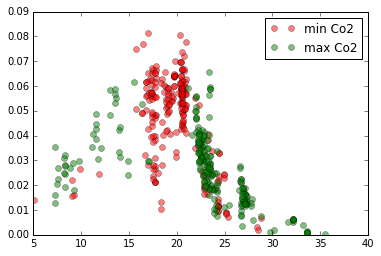

In [4]:
#plt.xscale('log')
#plt.yscale('log')

#plt.xlim(1e-2,1e0)
#plt.ylim(5e-2,1e0)

plt.plot( X[Y==y_lab[0],0]  , X[Y==y_lab[0],1]  , 'or' , alpha=0.5 , label='min Co2')
plt.plot( X[Y==y_lab[-1],0] , X[Y==y_lab[-1],1] , 'og' , alpha=0.5 , label='max Co2')
plt.legend()

In [5]:
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
#clf = svm.NuSVC()
clf.fit(X15, Y15)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

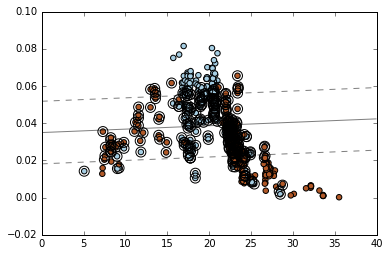

In [6]:
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.05,1)
#plt.ylim(2e-2,5)
plt.scatter(X15[:, 0], X15[:, 1], c=Y15, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax   = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
#plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

In [7]:
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)
clf.fit(X15, Y15)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=200, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app


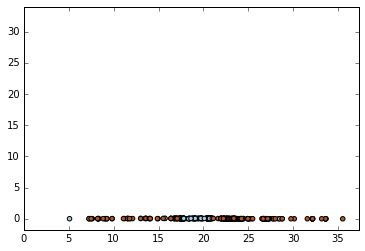

In [8]:
 #plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(0 ,1 ,50)
yy = np.linspace(28,34, 50)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X15[:, 0], X15[:, 1], c=Y15, cmap=plt.cm.Paired, edgecolor="black", s=20)

plt.axis("tight")
plt.show()

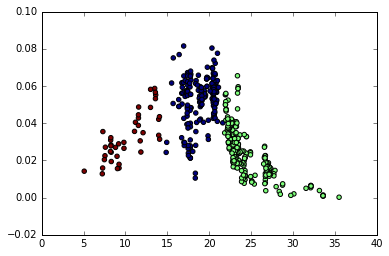

In [9]:
#plt.yscale('log')
y_pred = KMeans(n_clusters=3).fit_predict(X15)
plt.scatter(X15[:, 0], X15[:, 1], c=y_pred)

In [10]:
bandwidth       = estimate_bandwidth(X15, quantile=0.3)
print(bandwidth)

clustering      = MeanShift(bandwidth=bandwidth).fit(X15)
labels          = clustering.labels_
cluster_centers = clustering.cluster_centers_
labels_unique   = np.unique(labels)
n_clusters_     = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

3.048991256583783
number of estimated clusters : 4


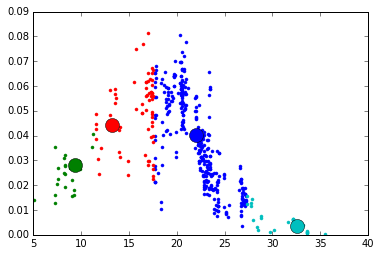

In [11]:
plt.figure(1)
plt.clf()
#plt.ylabel('NDV')
#plt.xlabel('CO2')

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members     = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X15[my_members, 0], X15[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,markeredgecolor='k', markersize=14)
plt.show()

In [12]:
clf = svm.NuSVC(nu=0.2,gamma="auto")
clf.fit(X15, Y15)
#print(X.shape,np.min(X[:,0]),np.max(X[:,0]),np.min(X[:,1]),np.max(X[:,1]))

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.2, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

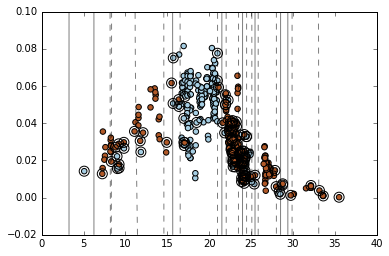

In [13]:
plt.scatter(X15[:, 0], X15[:, 1], c=Y15, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax   = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
#plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

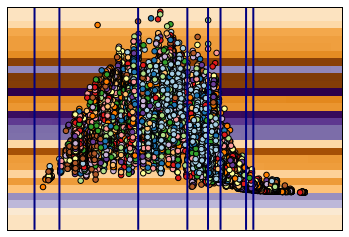

In [14]:
# plot the decision function
ax   = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
XX = np.linspace(xlim[0], xlim[1], 30)
YY = np.linspace(ylim[0], ylim[1], 30)

yy, xx = np.meshgrid(yy, xx)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles='-')
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
#plt.axis([395, 408, 0, 16000])
plt.show()

[Text(172.10812500000003, 214.6153846153846, 'X[0] <= 21.945\nentropy = 0.5\nsamples = 465\nvalue = [232, 233]'),
 Text(63.61200000000001, 197.44615384615383, 'X[0] <= 15.61\nentropy = 0.299\nsamples = 235\nvalue = [192, 43]'),
 Text(33.480000000000004, 180.27692307692308, 'X[1] <= 0.027\nentropy = 0.236\nsamples = 44\nvalue = [6, 38]'),
 Text(26.784000000000002, 163.1076923076923, 'X[0] <= 8.655\nentropy = 0.48\nsamples = 15\nvalue = [6, 9]'),
 Text(13.392000000000001, 145.93846153846152, 'X[0] <= 6.16\nentropy = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(6.696000000000001, 128.76923076923077, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(20.088, 128.76923076923077, 'entropy = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(40.176, 145.93846153846152, 'X[0] <= 13.36\nentropy = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(33.480000000000004, 128.76923076923077, 'X[1] <= 0.02\nentropy = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(26.784000000000002, 111.6, 'X[1] <= 0.017\nentropy = 0.4

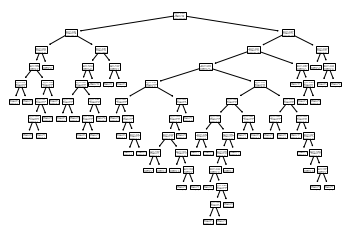

In [15]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X15, Y15)
tree.plot_tree(clf)